In [1]:
import numpy as np
import pandas as pd
from numpy import random

import matplotlib.pyplot as plt
from tqdm import tqdm

train_data_file = "./facebook_comment_volume/train.csv"
test_data_file = "./facebook_comment_volume/test.csv"

In [2]:
def train(x, y, lr=1e-4, max_iter=1000, batch_size=1024, shuffle=False, eps=1e-5):
    def iter_data(x, y):
        """
        Batchify dataset
        """
        index = np.arange(len(x))
        if shuffle:
            np.random.shuffle(index)
        for i in range(0, len(x), batch_size):
            span = slice(i, i + batch_size)
            yield x[index[span]], y[index[span]]
    
    def grad_func(x, y, theta):
        """
        Calculate gradient
        """
        n, p = len(y), len(theta)
        biased = np.ones((n, p))
        biased[:, 1:] = x
        y_ij = biased * theta
        y_pred = y_ij.sum(-1)
        diff = (y - y_pred)
        mse = np.mean(diff ** 2)
        grad = - 2 / n * diff @ biased
        return grad, mse

    y = y.reshape(-1)
    param_size = x.shape[1] + 1
    assert len(y) == x.shape[0], "Features and target sizes mismatch."
    
    # Initialize parameters
    theta = np.random.rand(param_size)
    
    prev_error = 1e100
    pbar = tqdm(range(max_iter), total=max_iter)
    batches = len(x) // batch_size + 1
    for _ in pbar:
        cum_loss = 0
        for x_batch, y_batch in iter_data(x, y):
            # Gradient descend
            grad, error = grad_func(x_batch, y_batch, theta)
            theta = theta - lr * grad
            if np.linalg.norm(grad) < eps:
                break
            prev_error = error
            cum_loss += error
        pbar.set_description(f"Loss: {cum_loss/batches:.4f}")
    return theta

In [3]:
def prediction(x, theta):
    n, p = len(x), len(theta)
    assert (n, p - 1) == x.shape, f"Data and parameters sizes mismatch."
    
    biased = np.ones((n, p))
    biased[:, 1:] = x
    return biased @ theta

In [4]:
def metrics(y, y_pred):
    mse = np.mean((y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(y)
    return rmse, r2

def linear_normalization(train, *args):
    t_min = train.min(axis=0, keepdims=True)
    t_max = train.max(axis=0, keepdims=True)
    t_s = (t_max - t_min)
    t_s[t_s == 0] = 1
    return tuple((part - t_min) / t_s for part in [train, *args])

def standard_score_normalization(train, *args):
    mean = train.mean(axis=0, keepdims=True)
    std = train.std(axis=0, keepdims=True)
    std[std == 0] = 1
    return tuple((part-mean)/std for part in [train, *args])
    

In [5]:
def plot_2d(x, y, a, b):
    x = x.reshape(-1)
    y = y.reshape(-1)

    plt.scatter(x, y)
    plt.plot(x, b * x + a, c="r")

### Train model on dummy dataset

Loss: 0.0000: 100%|██████████| 1000/1000 [00:00<00:00, 1035.99it/s]


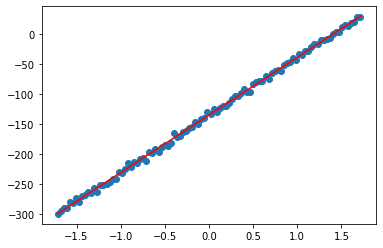

In [6]:
n_samples = 100
x = np.linspace(-100, 10, n_samples).reshape(-1, 1)
weights = np.array([3.])
y = x @ weights + 3 * np.random.randn(n_samples)
x, = linear_normalization(x)
x, = standard_score_normalization(x)

theta = train(x, y, 1e-1)
a, b = theta

plot_2d(x, y, a, b)

In [7]:
def kfold(x, k=5, shuffle=True):
    index = np.arange(len(x))
    if shuffle:
        random.shuffle(index)
    chunks = np.array_split(index, k)
    for i in range(k):
        train_index = np.concatenate(tuple(ch for j, ch in enumerate(chunks) if j != i))
        test_index = chunks[i]
        yield train_index, test_index

### Train model with 5 folds on Facebook Comment Volume dataset

In [8]:
df = pd.read_csv(train_data_file, header=None)
x = df.values[:,:-1]
y = df.values[:,-1]

metric_log = []

for i, (train_idx, test_idx) in enumerate(kfold(x)):
    train_x, train_y = x[train_idx], y[train_idx]
    test_x, test_y = x[test_idx], y[test_idx]
    
    train_x, test_x = standard_score_normalization(train_x, test_x)
    
    # Train model and make predictions for Train and Test parts.
    theta = train(train_x, train_y, lr=0.001, shuffle=True)
    train_pred_y = prediction(train_x, theta)
    pred_y = prediction(test_x, theta)
    
    # Calculate metrics for Train and Test predictions.
    train_rmse, train_r2 = metrics(train_y, train_pred_y)
    rmse, r2 = metrics(test_y, pred_y)
    
    metric_log.append([train_rmse, rmse, train_r2, r2] + list(theta))

mean = np.mean(metric_log, axis=0)
std = np.std(metric_log, axis=0)

columns = ["Train RMSE", "Test RMSE", "Train R2", "Test R2"] + [f"p{p+1}" for p in range(len(theta))]
index = [f"Fold {i+1}" for i in range(len(metric_log))] + ["Mean"] + ["Std"]

df = pd.DataFrame(np.array(metric_log + [mean] + [std]),
                  columns=columns,
                  index=index)

pd.set_option('display.max_columns', 1000)
display(df)

Loss: 846.2901: 100%|██████████| 1000/1000 [00:12<00:00, 83.10it/s]


,Train RMSE,Test RMSE,Train R2,Test R2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54
Fold 1,29.273844,29.150325,0.323562,0.310089,7.291322,0.289808,-0.515888,-1.760432,-0.121903,-0.911252,1.604900,0.823715,0.277827,3.722411,-1.420466,-0.847327,2.086890,2.972058,0.112946,-0.122953,1.513785,2.704796,3.967850,-1.392793,0.280635,-2.697869,-2.400529,-2.623685,0.183677,0.222116,-0.022573,0.887525,0.307373,-0.884366,0.569772,10.923749,3.821374,-2.922667,7.095880,-3.942319,-0.011955,2.467740,0.357315,0.860925,0.163650,0.059865,0.255926,0.706565,0.536355,0.679390,0.163961,0.253263,0.653099,0.435630,0.928870,0.394663,0.429821,0.178694
Fold 2,29.460760,29.488864,0.326624,0.239492,7.331820,-1.742127,-0.525301,-0.789018,-0.085895,0.636554,1.866287,0.857517,0.917132,3.755649,-1.078185,-0.740077,1.512341,3.615352,-0.079977,0.055698,0.942047,1.564534,2.541456,-1.143989,-0.814225,-2.768764,-1.670747,-1.474508,-0.030491,-0.055250,0.721615,0.740846,-1.070785,-1.823872,-0.794381,10.720999,3.476699,-2.456859,6.840660,-4.019202,0.007457,4.431497,0.510149,0.705188,0.225551,0.216943,0.324824,0.597260,0.412777,0.540072,0.203918,0.324173,0.596991,0.435444,0.699162,0.390204,0.407405,0.281236
Fold 3,28.718107,31.210252,0.332264,0.283062,7.279704,0.646715,-0.549239,-2.006348,-0.053280,0.844024,2.539500,1.856162,0.260061,4.619396,-2.374818,-0.476737,1.760746,4.439610,-1.596117,0.111685,0.256348,1.694261,2.697079,-1.278650,-0.510991,-3.477171,-1.580369,-2.718637,-0.685557,-0.941752,0.433314,1.431163,-0.794189,-0.874792,-0.238444,11.137323,3.660935,-2.249833,7.051026,-3.906154,-0.022708,2.272880,0.065053,0.894068,0.185843,0.374278,0.375239,0.910157,0.568707,0.496213,0.309178,0.501875,0.877443,0.418154,0.859466,0.341986,0.460712,0.377938
Fold 4,29.426834,28.452214,0.321262,0.322831,7.477808,0.153739,-0.652697,-1.818991,-0.079189,0.045978,2.408939,3.071693,0.024854,4.510644,-2.069140,-0.253270,1.571337,3.223392,-1.243032,0.455070,1.502812,2.105834,1.991297,-1.130743,-0.569187,-3.107104,-0.612175,-2.222918,-0.562239,0.557937,0.351670,1.307595,-0.139662,-2.346415,0.656780,11.361897,3.175281,-2.880463,6.566913,-4.077232,0.039000,2.476408,0.305917,0.894246,0.375218,0.293766,0.269303,0.832010,0.799222,0.867519,0.528456,0.197960,0.586990,0.539718,0.881103,0.593620,0.605741,0.217510
Fold 5,29.083284,29.996101,0.313670,0.342942,7.232730,0.438889,-0.299305,-2.233225,-0.052575,0.314571,1.954147,1.430125,1.417339,4.465436,-0.215983,0.260859,0.243549,3.715431,-0.897599,0.042124,2.127052,0.958264,3.069868,0.122439,-0.446053,-3.271096,-2.070988,-1.789177,-0.377328,0.979576,0.672919,0.884447,0.148818,-2.337721,0.748879,10.720626,3.675144,-3.149768,6.805543,-4.008036,0.090211,2.559361,0.124904,0.717858,0.297312,0.261936,0.180082,0.431215,0.561922,0.723927,0.242365,0.281745,0.709994,0.408426,0.780588,0.542115,0.617773,0.317760
Mean,29.192566,29.659551,0.323476,0.299683,7.322677,-0.042595,-0.508486,-1.721603,-0.078568,0.185975,2.074754,1.607842,0.579443,4.214707,-1.431718,-0.411310,1.434973,3.593168,-0.740756,0.108325,1.268409,1.805538,2.853510,-0.964747,-0.411964,-3.064401,-1.666962,-2.165785,-0.294388,0.152526,0.431389,1.050315,-0.309689,-1.653433,0.188521,10.972919,3.561887,-2.731918,6.872004,-3.990589,0.020401,2.841577,0.272668,0.814457,0.249515,0.241357,0.281075,0.695441,0.575797,0.661424,0.289575,0.311803,0.684903,0.447474,0.829838,0.452518,0.504290,0.274628
Std,0.272202,0.923477,0.006135,0.035818,0.083749,0.865381,0.115371,0.494680,0.025484,0.612551,0.348263,0.826311,0.513157,0.391742,0.761429,0.394783,0.628522,0.500883,0.659387,0.190202,0.629794,0.580893,0.656327,0.551981,0.368020,0.295524,0.603564,0.477133,0.325523,0.647121,0.266462,0.268709,0.535520,0.659586,0.604486,0.248139,0.222122,0.328972,0.190078,0.060149,0.040724,0.800501,0.161000,0.085011,0.077572,0.104282,0.065957,0.169902,0.125134,0.133211,0.128681,0